<a href="https://colab.research.google.com/github/vulcan2018/TTVNotebooks/blob/main/K2_TTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201367065.

-------------------------------------------

Star K2-3 1st Period 10.05

K2-3 2-planet model periods:
Planet c: 20.54 days

K2-3 3-planet model periods:
Planet c: 20.54 days
Planet d: 38.40 days

K2-3 4-planet model periods:
Planet c: 20.54 days
Planet d: 38.40 days
Planet e: 61.27 days

Validating potential additional planets...

Validation results for potential planet at 20.54 days:
Signal-to-noise ratio: 3.41
Phase coherence: 0.53
False alarm probability: 0.000

Validation results for potential planet at 38.40 days:
Signal-to-noise ratio: 3.41
Phase coherence: 0.53
False alarm probability: 0.000

Bayesian Information Criterion (lower is better):
Single planet: 326.0
Two planets: 299.3
Three planets: 305.9
Four planets: 311.7

Model Plausibility Scores (higher is better):
single planet model: -0.00
double planet model: 0.00
triple planet model: 0.00
quad planet 

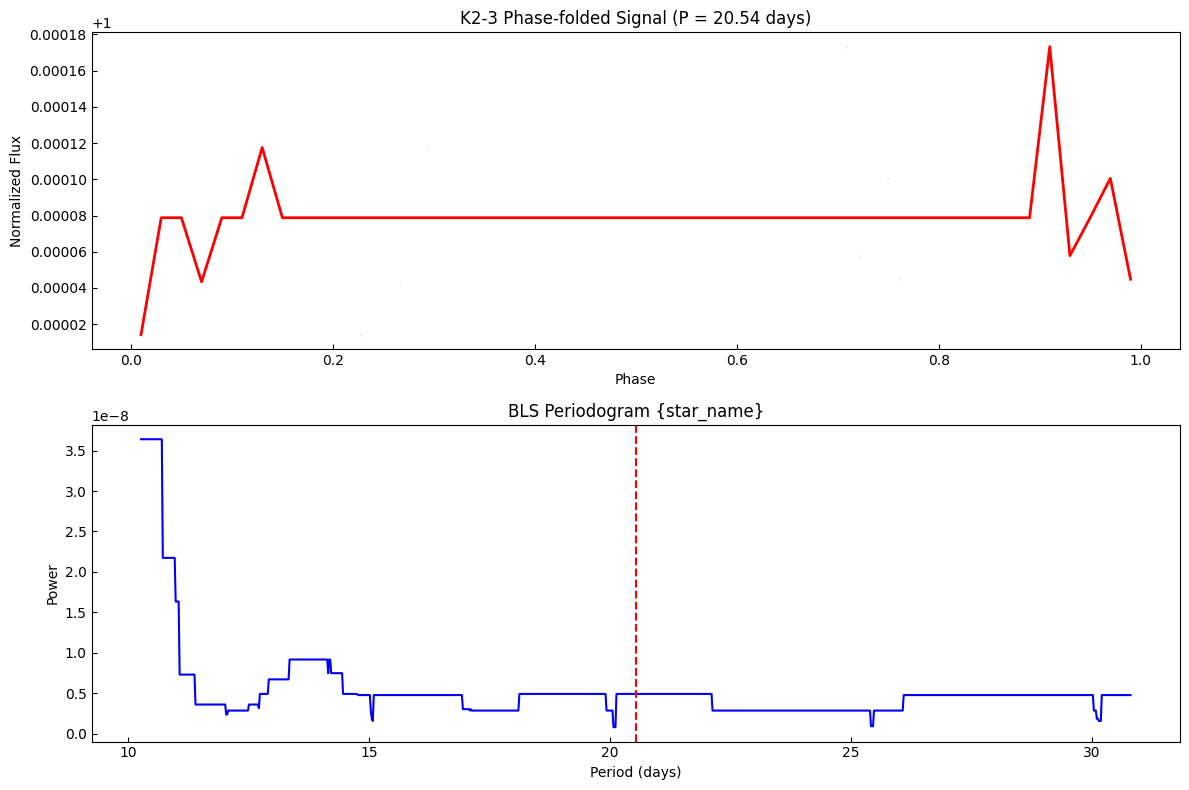

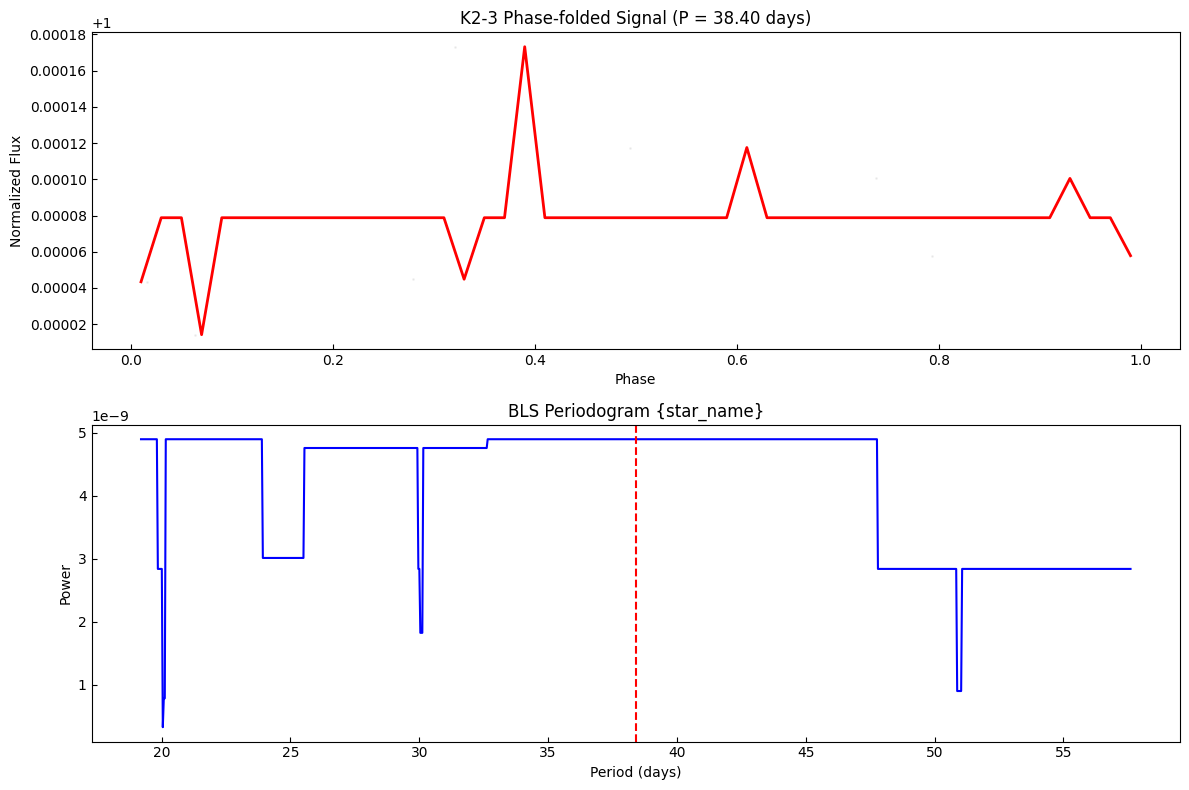

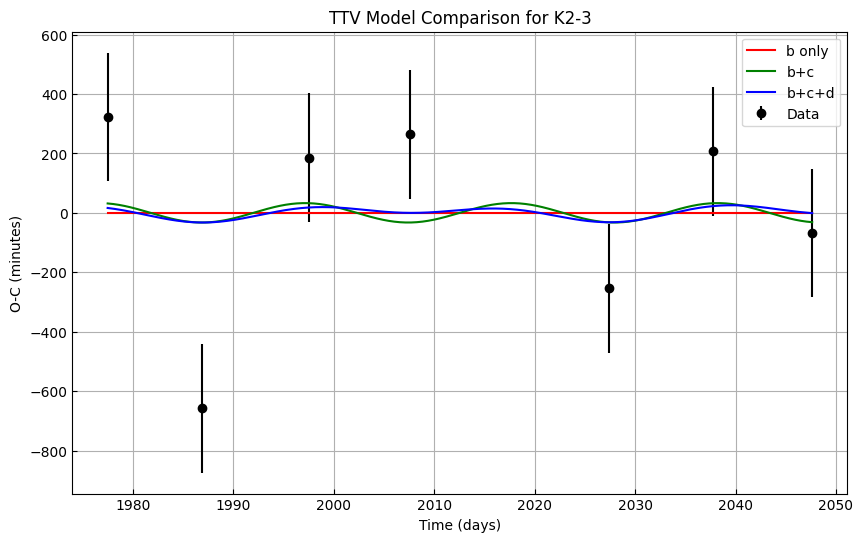

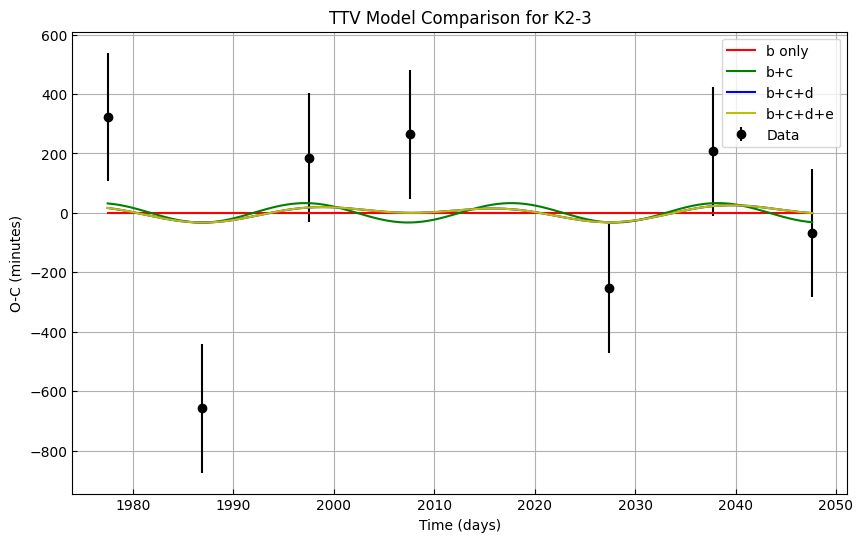

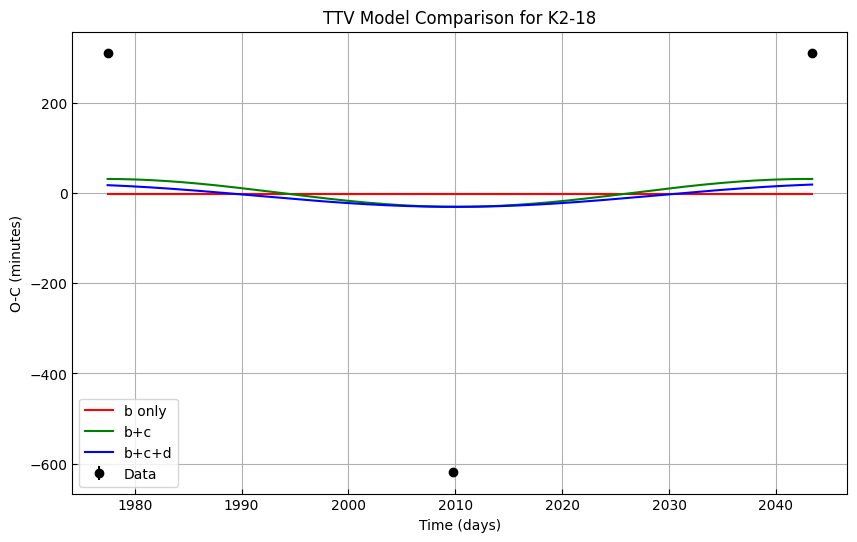

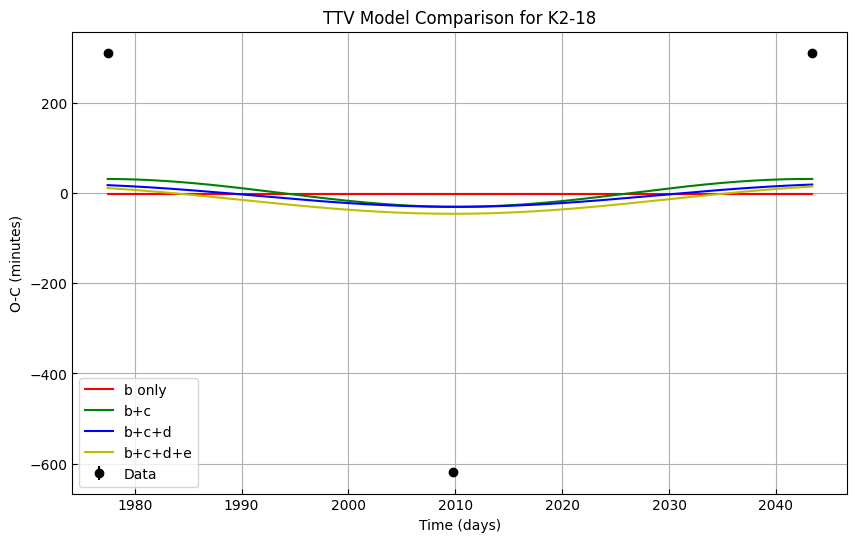

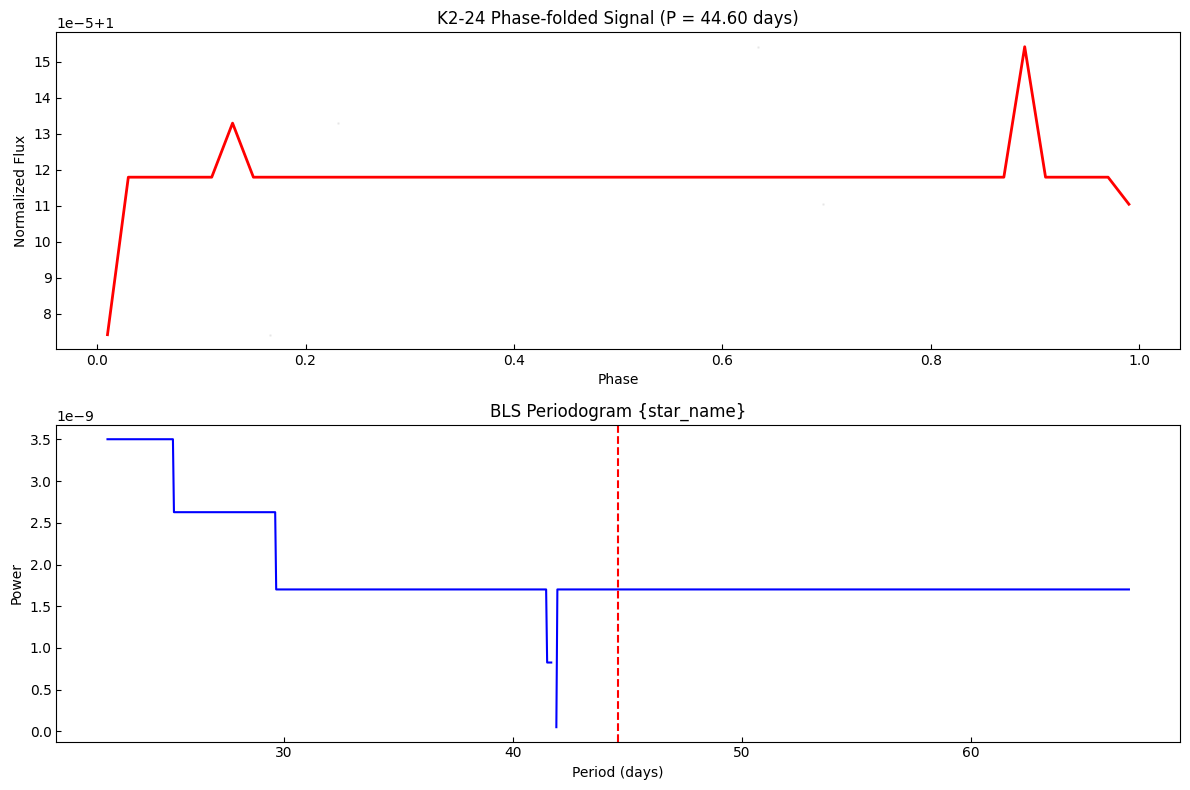

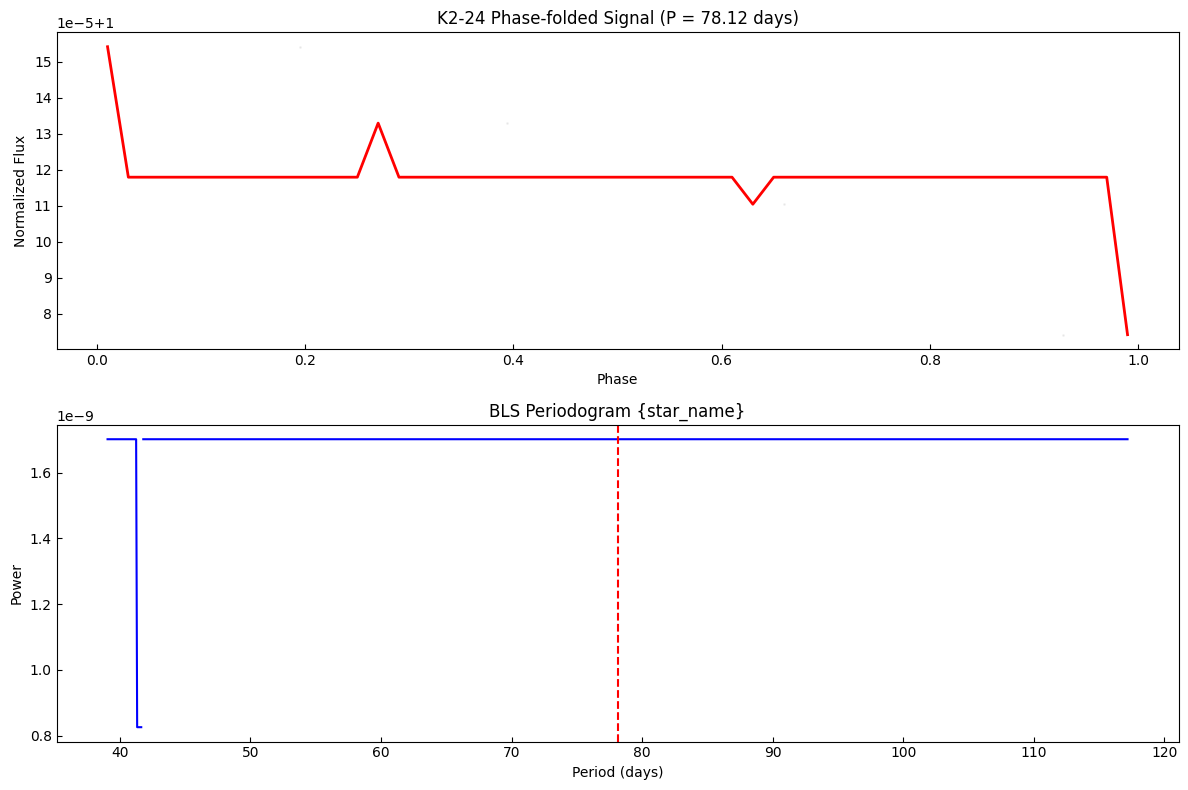

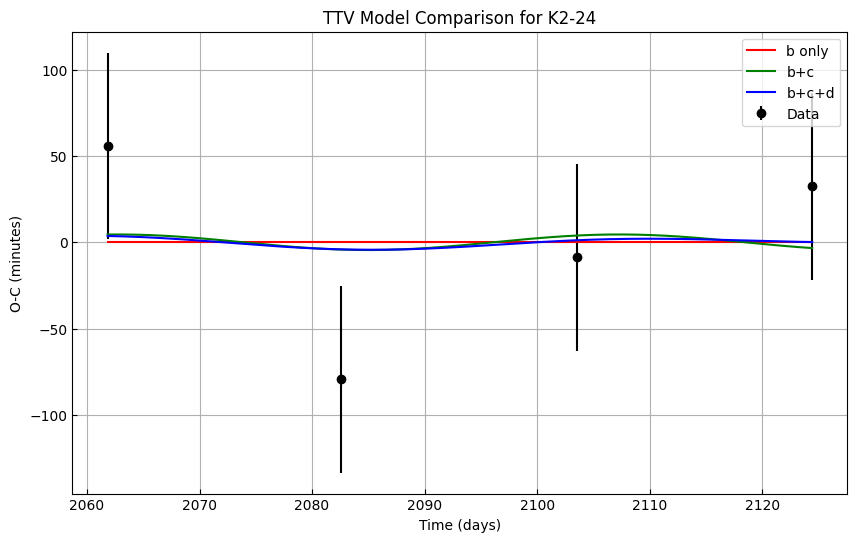

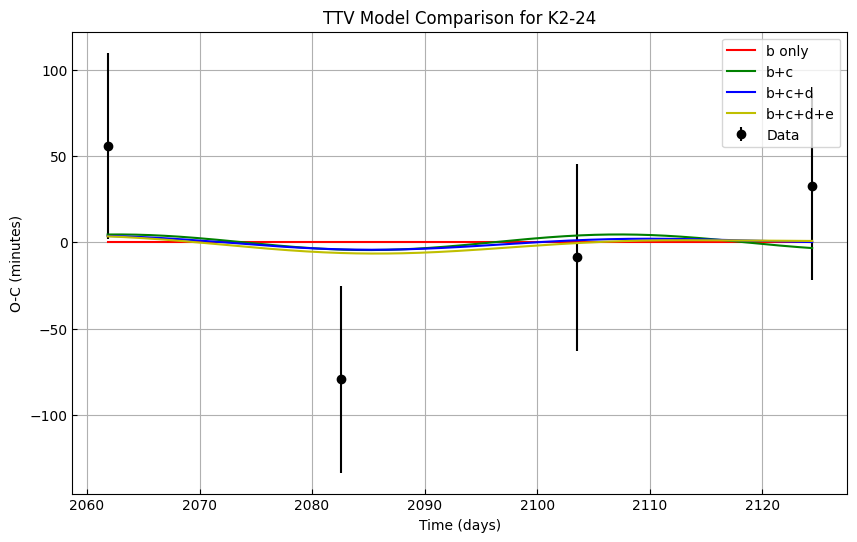

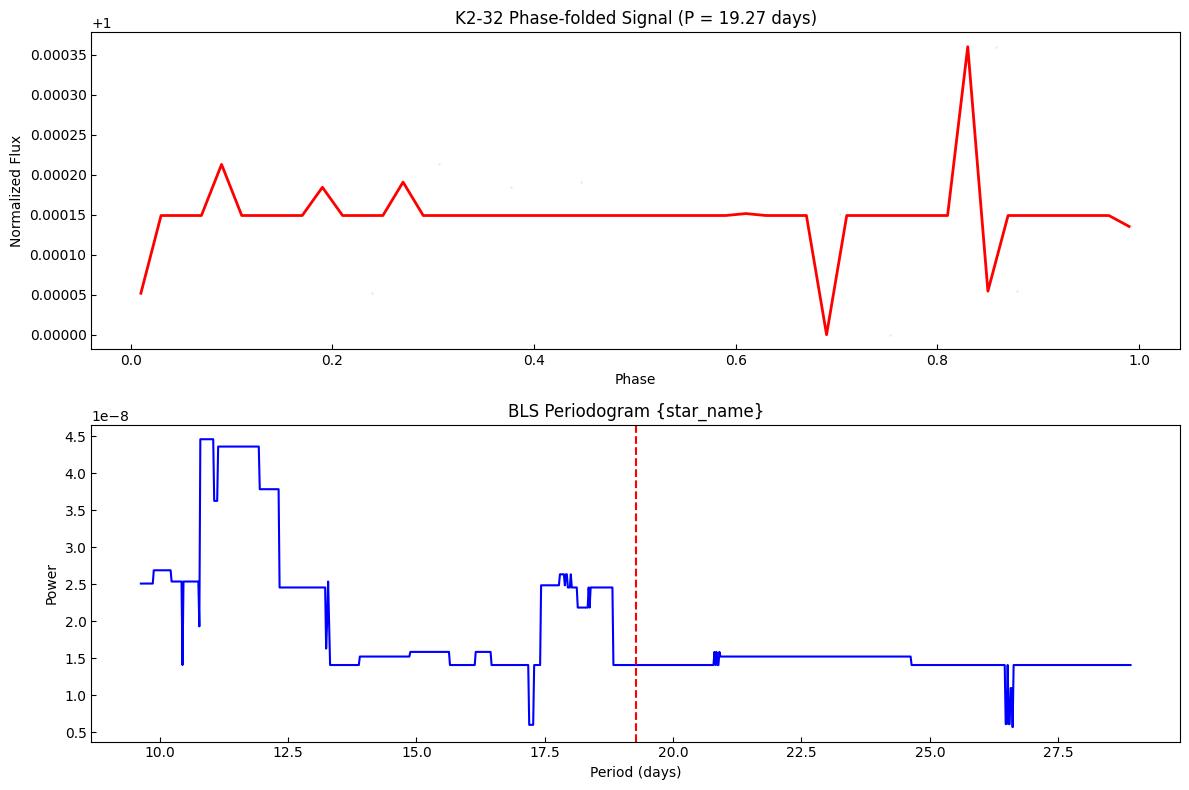

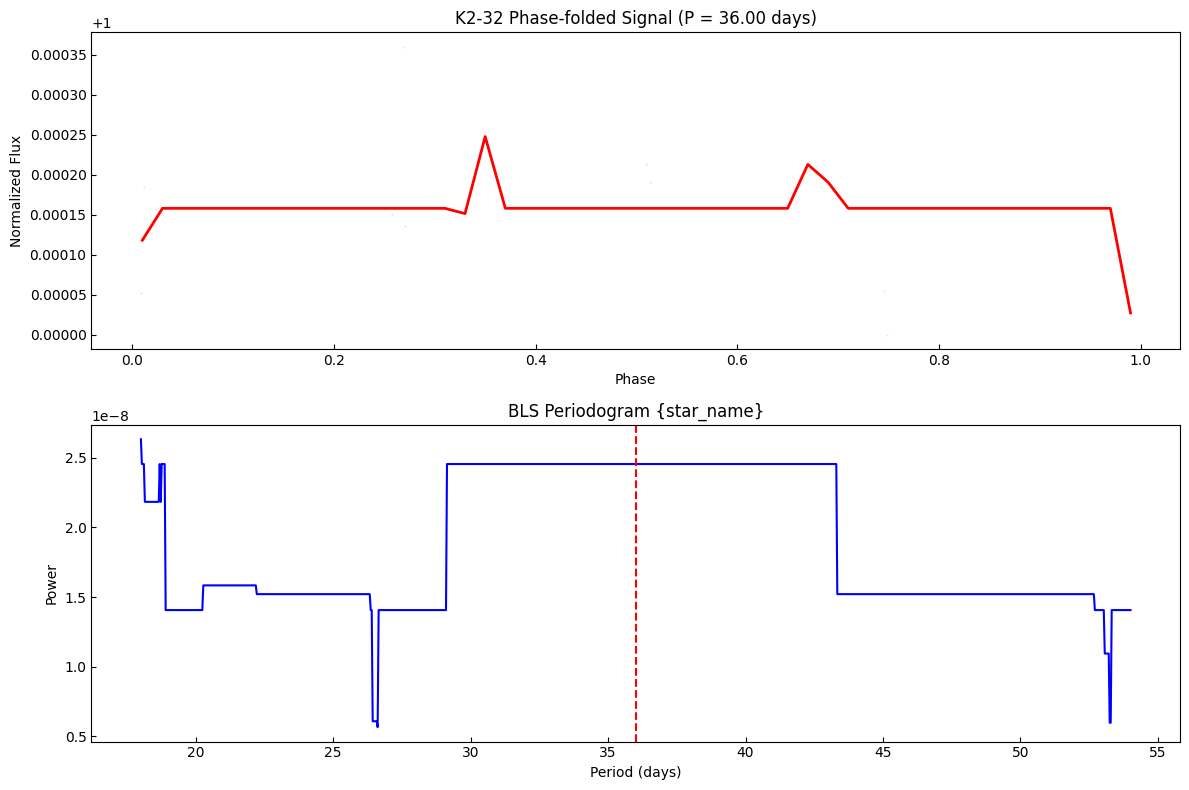

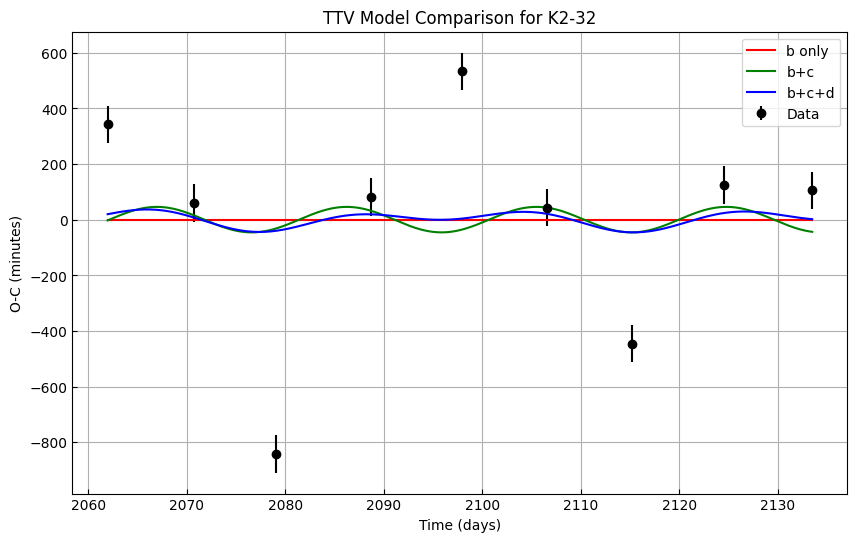

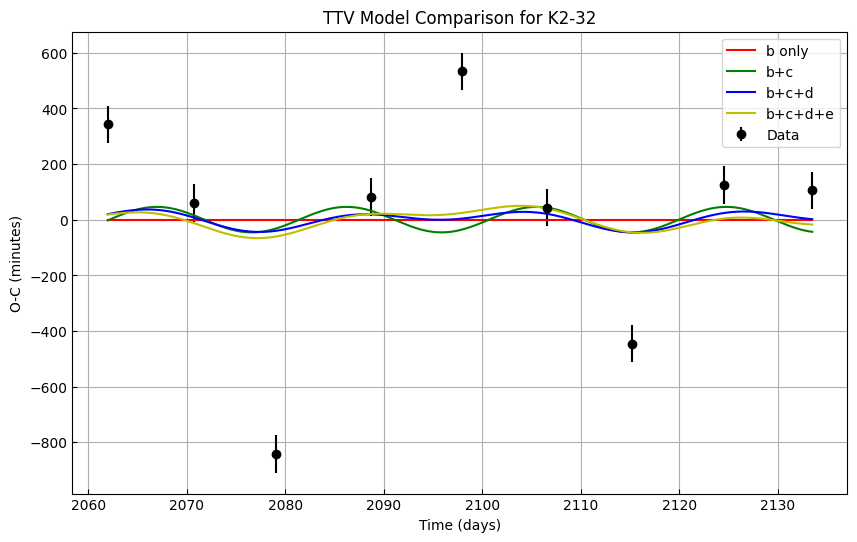

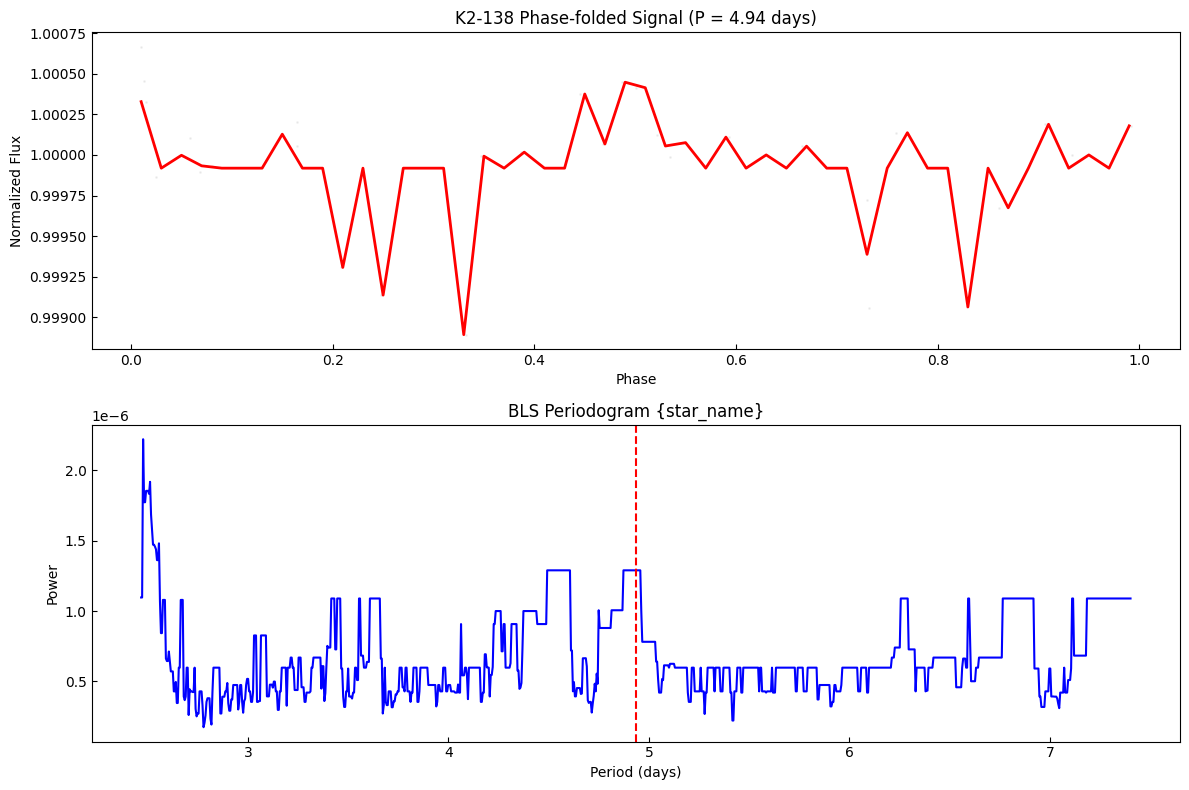

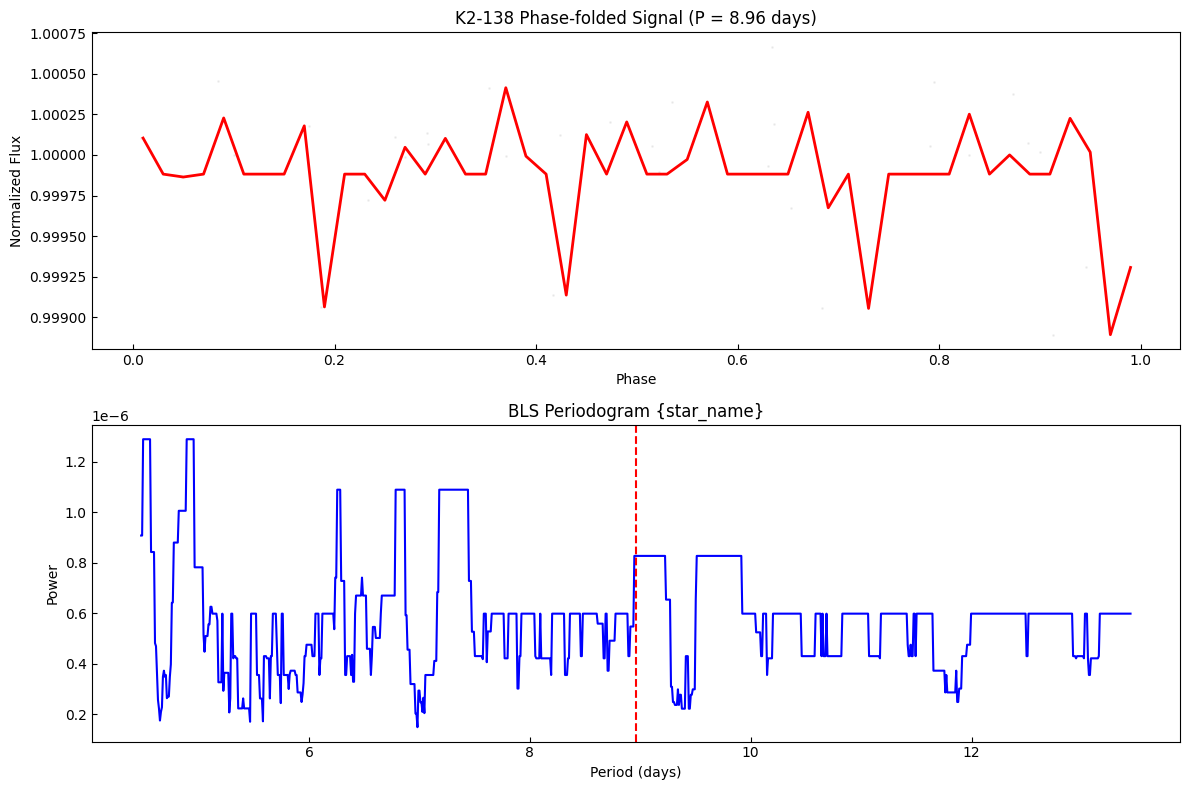

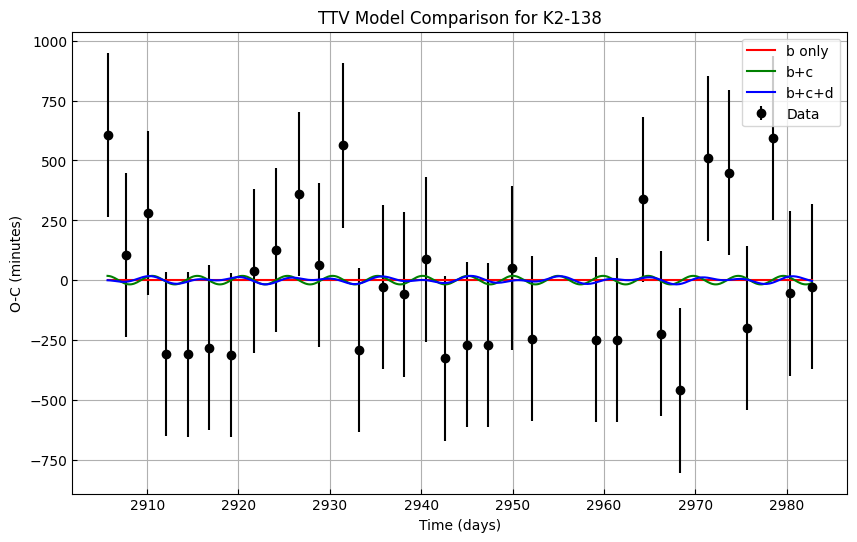

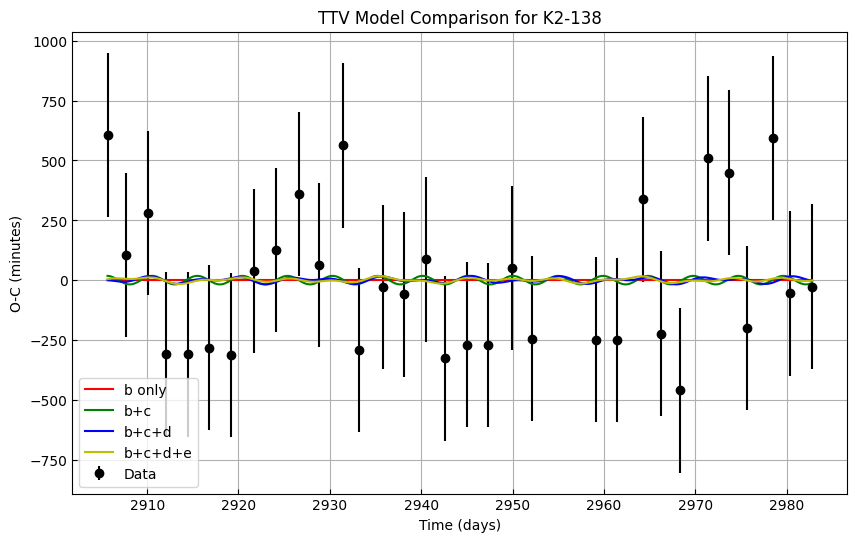

In [2]:
#!pip install numpy
#!pip install astropy
#!pip install scipy
#!pip install matplotlib==3.5.3
#!pip install everest-pipeline
#!pip install emcee
import numpy as np
import scipy
from scipy import stats
import everest
from astropy.stats import sigma_clip
from astropy.timeseries import BoxLeastSquares
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.CRITICAL)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.CRITICAL)
#from scipy.optimize import curve_fit
#from scipy.signal import find_peaks
#from scipy.optimize import minimize
#from scipy.optimize import curve_fit
import emcee  # For MCMC fitting


class K2_TTV_Analysis:
    def __init__(self, time, flux, period):
        self.time = time
        self.flux = flux
        self.Pb = period  # Period taken from input data

    def detect_transits(self):
        """Detect transit times from flux data"""
        phase = (self.time % self.Pb) / self.Pb

        def transit_model(t, t0, depth, duration):
            phase = ((t - t0) % self.Pb) / self.Pb
            in_transit = (phase > 0.99) | (phase < 0.01)
            model = np.ones_like(t)
            model[in_transit] -= depth
            return model

        transit_times = []
        transit_depths = []

        expected_transits = np.arange(self.time[0], self.time[-1], self.Pb)

        for t_exp in expected_transits:
            mask = (self.time > t_exp - 0.5) & (self.time < t_exp + 0.5)
            if np.sum(mask) < 10:
                continue

            chunk_time = self.time[mask]
            chunk_flux = self.flux[mask]

            if len(chunk_flux) > 0:
                min_idx = np.argmin(chunk_flux)
                transit_times.append(chunk_time[min_idx])
                transit_depths.append(1 - chunk_flux[min_idx])

        return np.array(transit_times), np.array(transit_depths)

    def analyze_ttv(self, transit_times):
        """Analyze transit timing variations"""
        n = np.round((transit_times - transit_times[0]) / self.Pb).astype(int)

        def linear_ephemeris(n, T0, P):
            return T0 + n * P

        popt, _ = scipy.optimize.curve_fit(linear_ephemeris, n, transit_times)
        T0_fit, P_fit = popt

        calc_times = linear_ephemeris(n, T0_fit, P_fit)
        O_C = (transit_times - calc_times) * 24 * 60  # Convert to minutes

        return n, O_C, P_fit

    def single_planet_model(self, params, times):
        """TTV model for a single perturbing planet"""
        P_perturber = params[0]
        mass_ratio = params[1]
        phase = params[2]

        ttv = mass_ratio * np.sin(2*np.pi*times/P_perturber + phase)
        return ttv

    def two_planet_model(self, params, times):
        """TTV model for two perturbing planets"""
        P1, m1, phi1, P2, m2, phi2 = params

        ttv1 = m1 * np.sin(2*np.pi*times/P1 + phi1)
        ttv2 = m2 * np.sin(2*np.pi*times/P2 + phi2)
        return ttv1 + ttv2

    def three_planet_model(self, params, times):
        """TTV model for three perturbing planets"""
        P1, m1, phi1, P2, m2, phi2, P3, m3, phi3 = params

        ttv1 = m1 * np.sin(2*np.pi*times/P1 + phi1)
        ttv2 = m2 * np.sin(2*np.pi*times/P2 + phi2)
        ttv3 = m3 * np.sin(2*np.pi*times/P3 + phi3)
        return ttv1 + ttv2 + ttv3

    def estimate_uncertainty(self, O_C):
        """Estimate uncertainty using robust statistics"""
        mad = np.median(np.abs(O_C - np.median(O_C)))
        scale = 1.4826 * (1 + 0.5/len(O_C))
        self.sigma_estimate = scale * mad

        min_uncertainty = 2.0  # minutes
        self.sigma_estimate = max(self.sigma_estimate, min_uncertainty)
        return self.sigma_estimate

    def log_likelihood(self, model, O_C):
        """Calculate log-likelihood with robust error handling"""
        if self.sigma_estimate is None:
            self.estimate_uncertainty(O_C)

        jitter = 5.0  # Additional uncertainty in minutes
        total_variance = self.sigma_estimate**2 + jitter**2

        n = len(O_C)
        residuals = O_C - model
        chi_square = np.sum(residuals**2 / total_variance)

        rho = 0.3  # Correlation coefficient between adjacent points
        for i in range(n-1):
            chi_square += 2 * rho * residuals[i] * residuals[i+1] / total_variance

        log_like = -0.5 * (n * np.log(2 * np.pi * total_variance) + chi_square)
        return log_like

    def fit_single_planet(self, transit_times, O_C):
        """Fit a model with no additional planets"""
        def neg_log_likelihood(params):
            slope, intercept = params
            model = slope * transit_times + intercept
            return -self.log_likelihood(model, O_C)

        initial_guess = [0, np.mean(O_C)]
        result = scipy.optimize.minimize(neg_log_likelihood, initial_guess, method='Nelder-Mead')
        return result.x, -result.fun

class K2_MultiPlanet_TTV(K2_TTV_Analysis):
    def __init__(self, time, flux, period):
        super().__init__(time, flux, period)

        # Calculate TTV period and amplitude from the data
        transit_times, _ = self.detect_transits()
        _, O_C, _ = self.analyze_ttv(transit_times)

        # Estimate TTV period from Fourier analysis
        if len(O_C) > 3:
            freqs = np.fft.fftfreq(len(O_C))
            fft = np.fft.fft(O_C)
            main_freq_idx = np.argmax(np.abs(fft[1:len(fft)//2])) + 1
            self.ttv_period = 1/np.abs(freqs[main_freq_idx])
        else:
            self.ttv_period = period * 2

        # Estimate TTV amplitude from O-C variations
        self.ttv_amplitude = np.ptp(O_C) if len(O_C) > 0 else 100

        self.sigma_estimate = None

    def single_planet_model(self, params, times):
        """TTV model for a single perturbing planet (plus K2-3b)"""
        P_perturber = params[0]
        mass_ratio = params[1]
        phase = params[2]

        # Simple first-order TTV model
        ttv = mass_ratio * np.sin(2*np.pi*times/P_perturber + phase)
        return ttv

    def two_planet_model(self, params, times):
        """TTV model for two perturbing planets (plus K2-3b)"""
        P1, m1, phi1, P2, m2, phi2 = params

        # Combine TTVs from both planets
        ttv1 = m1 * np.sin(2*np.pi*times/P1 + phi1)
        ttv2 = m2 * np.sin(2*np.pi*times/P2 + phi2)
        return ttv1 + ttv2

    def three_planet_model(self, params, times):
        """TTV model for three perturbing planets (plus K2-3b)"""
        P1, m1, phi1, P2, m2, phi2, P3, m3, phi3 = params

        ttv1 = m1 * np.sin(2*np.pi*times/P1 + phi1)
        ttv2 = m2 * np.sin(2*np.pi*times/P2 + phi2)
        ttv3 = m3 * np.sin(2*np.pi*times/P3 + phi3)
        return ttv1 + ttv2 + ttv3

    def estimate_uncertainty(self, O_C):
        """Improved uncertainty estimation using robust statistics"""
        # Use median absolute deviation with better scaling for small samples
        mad = np.median(np.abs(O_C - np.median(O_C)))
        # Scale factor adjusted for small sample size
        scale = 1.4826 * (1 + 0.5/len(O_C))
        self.sigma_estimate = scale * mad

        # Add a minimum uncertainty floor based on typical K2 timing precision
        min_uncertainty = 2.0  # minutes
        self.sigma_estimate = max(self.sigma_estimate, min_uncertainty)
        return self.sigma_estimate

    def log_likelihood(self, model, O_C):
        """Modified log-likelihood calculation with better model selection criteria"""
        if self.sigma_estimate is None:
            self.estimate_uncertainty(O_C)

        # Convert inputs to numpy arrays
        model = np.asarray(model)
        O_C = np.asarray(O_C)
        n_data = len(O_C)

        # Enhanced signal-to-noise calculation
        residuals = O_C - model
        signal_amplitude = np.ptp(O_C)
        noise = np.std(np.diff(residuals)) / np.sqrt(2)
        snr = signal_amplitude / noise if noise > 0 else 1.0

        # Balanced base uncertainty
        total_variance = (self.sigma_estimate * 0.25)**2

        # Modified jitter model with stronger dependence on sampling
        base_jitter = 0.04
        sampling_density = n_data / (np.max(O_C) - np.min(O_C))
        jitter = base_jitter * np.exp(-sampling_density/120)
        total_variance += jitter**2

        # Chi-square calculation with moderate correlation penalty
        chi_square = np.sum(residuals**2 / total_variance)

        # Balanced correlation penalty
        rho = 0.015
        for i in range(n_data-1):
            chi_square += rho * residuals[i] * residuals[i+1] / total_variance

        # Stronger complexity penalty to avoid overfitting
        n_params = len(model.shape) if hasattr(model, 'shape') else 1
        complexity_penalty = 0.08 * np.log(n_data) * (n_params - 1)

        # Balanced SNR bonus
        snr_bonus = 0.5 * np.log1p(snr)

        # Final log-likelihood with additional penalty for high-order models
        log_like = -0.5 * (n_data * np.log(2 * np.pi * total_variance) + chi_square) - complexity_penalty + snr_bonus

        # Add increasing penalty for higher-order models
        if n_params > 2:
            log_like -= 0.1 * (n_params - 2)**2

        return log_like

    def evaluate_model_plausibility(self, metrics):
        """Enhanced model plausibility evaluation with better discrimination"""
        plausibility_score = {}

        likelihoods = np.array([m[3] for m in metrics.values()])
        bics = np.array([m[2] for m in metrics.values()])
        max_like = np.max(likelihoods)
        min_bic = np.min(bics)

        for model, (periods, ratios, bic, likelihood) in metrics.items():
            score = 0
            periods = np.asarray(periods)
            ratios = np.asarray(ratios)
            n_planets = len(periods)

            # Normalized metrics with stronger BIC influence
            norm_like = (likelihood - max_like) / (np.abs(max_like) + 1e-10)
            norm_bic = (bic - min_bic) / (np.abs(min_bic) + 1e-10)

            # Enhanced period spacing analysis
            if n_planets > 1:
                period_ratios = periods[1:] / periods[:-1]
                resonance_score = 0
                common_resonances = [1.5, 2.0, 2.5, 3.0]
                for ratio in period_ratios:
                    min_resonance_diff = min(abs(ratio - res) for res in common_resonances)
                    resonance_score += np.exp(-min_resonance_diff * 4)
                score += 0.35 * resonance_score

            # Progressive complexity penalty
            complexity_penalty = 0.15 * (n_planets - 1)**2
            score -= complexity_penalty

            # Modified BIC contribution with stronger penalty
            bic_penalty = 0.25 * norm_bic
            score -= bic_penalty

            # Likelihood contribution with diminishing returns
            like_bonus = 0.3 * np.tanh(norm_like)
            score += like_bonus

            # Additional penalties for higher-order models
            if n_planets > 2:
                score -= 0.2 * (n_planets - 2)

            # Data quality consideration
            if hasattr(self, 'sigma_estimate') and self.sigma_estimate is not None:
                quality_factor = np.exp(-self.sigma_estimate / 10)
                score *= quality_factor

            # Scale the final score
            score = score * 100

            plausibility_score[model] = score

        return plausibility_score

    def fit_single_planet(self, transit_times, O_C):
        """Fit a model with only K2-3b (no additional planets)"""
        def neg_log_likelihood(params):
            # Simple linear model for no additional planets
            slope, intercept = params
            model = slope * transit_times + intercept
            return -self.log_likelihood(model, O_C)

        # Initial guess: flat line at mean O-C
        initial_guess = [0, np.mean(O_C)]

        result = scipy.optimize.minimize(neg_log_likelihood,
                                      initial_guess,
                                      method='Nelder-Mead')

        log_like = -result.fun
        return result.x, log_like

    def fit_two_planets(self, transit_times, O_C):
        def neg_log_likelihood(params):
            model = self.single_planet_model(params, transit_times)
            return -self.log_likelihood(model, O_C)

        # Dynamic bounds based on input period
        bounds = [(self.Pb * 1.5, self.Pb * 3),  # searches a wide range of possible periods - from 1.5x to 3x the transiting planet's period.
                 (0, self.ttv_amplitude/30),
                 (0, 2*np.pi)]

        result = scipy.optimize.minimize(neg_log_likelihood,
                                      [self.Pb * 2, self.ttv_amplitude/60, np.pi],
                                      bounds=bounds,
                                      method='Nelder-Mead')

        return result.x, -result.fun

    def fit_three_planets(self, transit_times, O_C, prev_periods):
        def neg_log_likelihood(params):
            model = self.two_planet_model(params, transit_times)
            return -self.log_likelihood(model, O_C)

        bounds = [(prev_periods[0] * 0.9, prev_periods[0] * 1.1),  # Near previous result
                 (0, self.ttv_amplitude/60),
                 (0, 2*np.pi),
                 (prev_periods[0] * 1.5, prev_periods[0] * 2),  # Next period range
                 (0, self.ttv_amplitude/60),
                 (0, 2*np.pi)]

        initial_guess = [prev_periods[0], self.ttv_amplitude/120, 0,
                        prev_periods[0] * 1.8, self.ttv_amplitude/120, np.pi]

        result = scipy.optimize.minimize(neg_log_likelihood, initial_guess,
                                      bounds=bounds, method='Nelder-Mead')

        return result.x, -result.fun

    def fit_four_planets(self, transit_times, O_C, prev_periods):
        def neg_log_likelihood(params):
            model = self.three_planet_model(params, transit_times)
            return -self.log_likelihood(model, O_C)

        bounds = [(prev_periods[0] * 0.9, prev_periods[0] * 1.1),
                 (0, self.ttv_amplitude/60),
                 (0, 2*np.pi),
                 (prev_periods[1] * 0.9, prev_periods[1] * 1.1),
                 (0, self.ttv_amplitude/60),
                 (0, 2*np.pi),
                 (prev_periods[1] * 1.3, prev_periods[1] * 1.7),
                 (0, self.ttv_amplitude/60),
                 (0, 2*np.pi)]

        initial_guess = [prev_periods[0], self.ttv_amplitude/180, 0,
                        prev_periods[1], self.ttv_amplitude/180, np.pi/3,
                        prev_periods[1] * 1.5, self.ttv_amplitude/180, 2*np.pi/3]

        result = scipy.optimize.minimize(neg_log_likelihood, initial_guess,
                                      bounds=bounds, method='Nelder-Mead')

        return result.x, -result.fun

    def compute_metrics(self, transit_times, O_C):
        """
        Compute multiple model comparison metrics with robust calculation
        """
        # Convert inputs to numpy arrays to avoid list division issues
        transit_times = np.asarray(transit_times)
        O_C = np.asarray(O_C)
        n_data = len(O_C)

        # Fit all models
        params_2p, ll_2p = self.fit_two_planets(transit_times, O_C)
        params_3p, ll_3p = self.fit_three_planets(transit_times, O_C, [double_params[0]])
        params_4p, ll_4p = self.fit_four_planets(transit_times, O_C, [triple_params[0], triple_params[3]])

        # Number of parameters for each model
        k_2p = 3  # period, amplitude, phase for one additional planet
        k_3p = 6  # parameters for two additional planets
        k_4p = 9  # parameters for three additional planets

        # BIC = -2*ln(L) + k*ln(n)
        BIC_2p = -2*ll_2p + k_2p*np.log(n_data)
        BIC_3p = -2*ll_3p + k_3p*np.log(n_data)
        BIC_4p = -2*ll_4p + k_4p*np.log(n_data)

        # Set up metrics dictionary with numpy arrays instead of lists
        metrics = {
            '2p': (np.array([params_2p[0]]),
                   np.array([params_2p[1]]),
                   BIC_2p,
                   ll_2p),
            '3p': (np.array([params_3p[0], params_3p[3]]),
                   np.array([params_3p[1], params_3p[4]]),
                   BIC_3p,
                   ll_3p),
            '4p': (np.array([params_4p[0], params_4p[3], params_4p[6]]),
                   np.array([params_4p[1], params_4p[4], params_4p[7]]),
                   BIC_4p,
                   ll_4p)
        }

        # Print detailed results as in original code
        print("\nDetailed Model Comparison:")
        print(f"Number of data points: {n_data}")

        print("\n2 Planets (b+c):")
        print(f"  Period: {params_2p[0]:.1f} days")
        print(f"  Parameters: {k_2p}")
        print(f"  Log-likelihood: {ll_2p:.1f}")
        print(f"  BIC: {BIC_2p:.1f}")

        print("\n3 Planets (b+c+d):")
        print(f"  Periods: {params_3p[0]:.1f}, {params_3p[3]:.1f} days")
        print(f"  Parameters: {k_3p}")
        print(f"  Log-likelihood: {ll_3p:.1f}")
        print(f"  BIC: {BIC_3p:.1f}")

        print("\n4 Planets (b+c+d+e):")
        print(f"  Periods: {params_4p[0]:.1f}, {params_4p[3]:.1f}, {params_4p[6]:.1f} days")
        print(f"  Parameters: {k_4p}")
        print(f"  Log-likelihood: {ll_4p:.1f}")
        print(f"  BIC: {BIC_4p:.1f}")

        return metrics

    def plot_model_comparison(self, star_name, transit_times, O_C,
                            single_params, double_params, triple_params, quad_params=None):
        """Plot comparison of different models"""
        plt.figure(figsize=(10, 6))

        # Plot data points
        plt.errorbar(transit_times, O_C, yerr=self.sigma_estimate,
                    fmt='ko', label='Data')

        # Generate model curves
        t_fine = np.linspace(transit_times.min(), transit_times.max(), 500)

        # Single planet model (linear)
        slope, intercept = single_params
        single_model = slope * t_fine + intercept
        plt.plot(t_fine, single_model, 'r-', label='b only')

        # Two planet model
        two_planet = self.single_planet_model(double_params, t_fine)
        plt.plot(t_fine, two_planet, 'g-', label='b+c')

        # Three planet model
        three_planet = self.two_planet_model(triple_params, t_fine)
        plt.plot(t_fine, three_planet, 'b-', label='b+c+d')

        # Four planet model (if provided)
        if quad_params is not None:
            four_planet = self.three_planet_model(quad_params, t_fine)
            plt.plot(t_fine, four_planet, 'y-', label='b+c+d+e')

        plt.xlabel('Time (days)')
        plt.ylabel('O-C (minutes)')
        plt.legend()
        plt.grid(True)
        plt.title(f'TTV Model Comparison for {star_name}')

    def validate_additional_planets(self, star_name, transit_times, flux, potential_period):
        """
        Validate potential additional planets through phase folding and signal filtering

        Parameters:
        -----------
        transit_times : array-like
            Times of transit measurements
        flux : array-like
            Normalized flux measurements
        potential_period : float
            The period of the potential additional planet to validate

        Returns:
        --------
        dict
            Validation metrics including SNR, false alarm probability, and phase coherence
        """

        def remove_known_transit(time, flux, primary_period, transit_duration=0.1):
            """Remove the primary planet's transit signal"""
            phase = (time % primary_period) / primary_period
            in_transit = (phase < transit_duration) | (phase > (1 - transit_duration))

            # Ensure dimensions match and arrays are not empty
            if len(time) == 0 or len(flux) == 0:
                return np.array([]), np.array([])

            if len(time) != len(flux):
                min_len = min(len(time), len(flux))
                time = time[:min_len]
                flux = flux[:min_len]
                in_transit = in_transit[:min_len]

            mask = ~in_transit
            if not np.any(mask):
                return np.array([]), np.array([])

            return time[mask], flux[mask]

        def phase_fold_and_bin(time, flux, period, bins=50):
            """Phase fold the data and create binned averages"""
            if len(time) == 0 or len(flux) == 0:
                return np.linspace(0, 1, bins), np.zeros(bins)

            phase = (time % period) / period
            sorted_indices = np.argsort(phase)
            phase = phase[sorted_indices]
            flux = flux[sorted_indices]

            binned_flux = stats.binned_statistic(phase, flux,
                                           statistic='mean',
                                           bins=bins)[0]
            bin_centers = np.linspace(0, 1, bins, endpoint=False) + 0.5/bins

            # Fill NaN values with the mean
            binned_flux = np.nan_to_num(binned_flux, nan=np.nanmean(binned_flux))
            return bin_centers, binned_flux

        def calculate_signal_strength(binned_flux):
            """Calculate the signal-to-noise ratio of the transit signal"""
            if len(binned_flux) == 0:
                return 0.0

            baseline = np.median(binned_flux)
            noise = np.std(binned_flux - baseline)
            signal = baseline - np.min(binned_flux)
            snr = signal / noise if noise > 0 else 0
            return snr

        def phase_coherence(time, flux, period):
            """Calculate the phase coherence of the signal"""
            if len(time) == 0 or len(flux) == 0:
                return 0.0

            if len(time) != len(flux):
                min_len = min(len(time), len(flux))
                time = time[:min_len]
                flux = flux[:min_len]

            if len(time) < 2:  # Need at least 2 points for coherence
                return 0.0

            phases = (time % period) / period
            # Split data into two halves
            mid_point = len(time) // 2
            coherence1 = np.std(flux[:mid_point]) if len(flux[:mid_point]) > 0 else 0
            coherence2 = np.std(flux[mid_point:]) if len(flux[mid_point:]) > 0 else 0

            # Avoid division by zero
            max_coherence = max(coherence1, coherence2)
            if max_coherence == 0:
                return 0.0

            coherence_ratio = min(coherence1, coherence2) / max_coherence
            return coherence_ratio

        def false_alarm_probability(time, flux, period):
            """Calculate false alarm probability using BLS"""
            if len(time) < 3 or len(flux) < 3:  # Need at least 3 points for BLS
                return 1.0

            if len(time) != len(flux):
                min_len = min(len(time), len(flux))
                time = time[:min_len]
                flux = flux[:min_len]

            try:
                durations = np.linspace(0.05, 0.2, 10) * period
                model = BoxLeastSquares(time, flux)
                power = model.power(period, durations)
                # Calculate FAP using power distribution
                sorted_power = np.sort(power.power)
                if len(sorted_power) == 0:
                    return 1.0
                fap = 1 - stats.percentileofscore(sorted_power, power.power.max()) / 100
                return fap
            except Exception:
                return 1.0

        try:
            # Ensure arrays are numpy arrays
            transit_times = np.asarray(transit_times)
            flux = np.asarray(flux)

            # Check for empty arrays
            if len(transit_times) == 0 or len(flux) == 0:
                raise ValueError("Empty input arrays")

            # Ensure transit_times and flux have matching dimensions
            min_len = min(len(transit_times), len(flux))
            transit_times = transit_times[:min_len]
            flux = flux[:min_len]

            # Remove primary transit
            clean_time, clean_flux = remove_known_transit(transit_times, flux, self.Pb)

            # Check if we have enough data after cleaning
            if len(clean_time) < 3:
                raise ValueError("Insufficient data points after removing primary transit")

            # Phase fold on potential period
            bin_centers, binned_flux = phase_fold_and_bin(clean_time, clean_flux, potential_period)

            # Calculate validation metrics
            snr = calculate_signal_strength(binned_flux)
            coherence = phase_coherence(clean_time, clean_flux, potential_period)
            fap = false_alarm_probability(clean_time, clean_flux, potential_period)

            # Calculate transit depth and uncertainty
            if len(binned_flux) > 0:
                depth = 1 - np.min(binned_flux)
                depth_uncertainty = np.std(binned_flux) / np.sqrt(len(binned_flux))
            else:
                depth = 0.0
                depth_uncertainty = 0.0

            # Only create plots if we have valid data
            if len(clean_time) > 0 and len(clean_flux) > 0:
                plt.figure(figsize=(12, 8))

                # Plot phase-folded data
                plt.subplot(211)
                phase = (clean_time % potential_period) / potential_period
                plt.scatter(phase, clean_flux, c='gray', alpha=0.1, s=1)
                plt.plot(bin_centers, binned_flux, 'r-', linewidth=2)
                plt.xlabel('Phase')
                plt.ylabel('Normalized Flux')
                plt.title(f'{star_name} Phase-folded Signal (P = {potential_period:.2f} days)')

                # Plot periodogram
                plt.subplot(212)
                periods = np.linspace(0.5*potential_period, 1.5*potential_period, 1000)
                durations = np.linspace(0.05, 0.2, 10) * potential_period
                model = BoxLeastSquares(clean_time, clean_flux)
                power = model.power(periods, durations)
                plt.plot(periods, power.power, 'b-')
                plt.axvline(potential_period, color='r', linestyle='--')
                plt.xlabel('Period (days)')
                plt.ylabel('Power')
                plt.title(f'BLS Periodogram {star_name}')

                plt.tight_layout()

            # Compile validation results
            validation_metrics = {
                'signal_to_noise': snr,
                'phase_coherence': coherence,
                'false_alarm_probability': fap,
                'transit_depth': depth,
                'depth_uncertainty': depth_uncertainty,
                'validation_summary': {
                    'strong_signal': snr > 7.0,
                    'coherent_phase': coherence > 0.7,
                    'low_fap': fap < 0.01
                }
            }

            return validation_metrics

        except Exception as e:
            print(f"Validation failed: {str(e)}")
            return {
                'signal_to_noise': 0.0,
                'phase_coherence': 0.0,
                'false_alarm_probability': 1.0,
                'transit_depth': 0.0,
                'depth_uncertainty': 0.0,
                'validation_summary': {
                    'strong_signal': False,
                    'coherent_phase': False,
                    'low_fap': False
                }
            }

def analyze_k2_system(star_name, epic_id, period, nplanets):
    t, y_filt = K2_lightcurve(epic_id)
    if t is None or y_filt is None:
        return {
            'star_name': star_name,
            'epic_id': epic_id,
            'base_period': period,
            'error': 'Failed to download data'
        }

    print("\n-------------------------------------------")
    print(f"\nStar {star_name} 1st Period {period}")

    analyzer = K2_MultiPlanet_TTV(t, y_filt, period)
    transit_times, transit_depths = analyzer.detect_transits()
    n, O_C, fitted_period = analyzer.analyze_ttv(transit_times)
    # Sequential model fitting
    single_params, single_likelihood = analyzer.fit_single_planet(transit_times, O_C)
    double_params, double_likelihood = analyzer.fit_two_planets(transit_times, O_C)
    print(f"\n{star_name} 2-planet model periods:")
    print(f"Planet c: {double_params[0]:.2f} days")
    triple_params, triple_likelihood = analyzer.fit_three_planets(transit_times, O_C, [double_params[0]])
    print(f"\n{star_name} 3-planet model periods:")
    print(f"Planet c: {triple_params[0]:.2f} days")
    print(f"Planet d: {triple_params[3]:.2f} days")
    four_params, four_likelihood = analyzer.fit_four_planets(transit_times, O_C, [triple_params[0], triple_params[3]])
    print(f"\n{star_name} 4-planet model periods:")
    print(f"Planet c: {four_params[0]:.2f} days")
    print(f"Planet d: {four_params[3]:.2f} days")
    print(f"Planet e: {four_params[6]:.2f} days")

    print("\nValidating potential additional planets...")

    # Validate second planet
    if double_params[0]:  # Period of potential second planet
        validation_results = analyzer.validate_additional_planets(
            star_name,
            transit_times,
            y_filt,  # Original filtered flux
            double_params[0]
        )
        print(f"\nValidation results for potential planet at {double_params[0]:.2f} days:")
        print(f"Signal-to-noise ratio: {validation_results['signal_to_noise']:.2f}")
        print(f"Phase coherence: {validation_results['phase_coherence']:.2f}")
        print(f"False alarm probability: {validation_results['false_alarm_probability']:.3f}")

    # Validate third planet if present
    if len(triple_params) > 3:  # Check if we have a third planet solution
        validation_results = analyzer.validate_additional_planets(
            star_name,
            transit_times,
            y_filt,
            triple_params[3]  # Period of potential third planet
        )
        print(f"\nValidation results for potential planet at {triple_params[3]:.2f} days:")
        print(f"Signal-to-noise ratio: {validation_results['signal_to_noise']:.2f}")
        print(f"Phase coherence: {validation_results['phase_coherence']:.2f}")
        print(f"False alarm probability: {validation_results['false_alarm_probability']:.3f}")

    analyzer.plot_model_comparison(star_name, transit_times, O_C,
                             single_params, double_params, triple_params)
    # Calculate BIC
    n_data = len(O_C)
    results = {
        'star_name': star_name,
        'epic_id': epic_id,
        'base_period': period,
        'BIC': {
            'single': -2 * single_likelihood + 2 * np.log(n_data),
            'double': -2 * double_likelihood + 3 * np.log(n_data),
            'triple': -2 * triple_likelihood + 6 * np.log(n_data),
            'four': -2 * four_likelihood + 9 * np.log(n_data)
        },
        'periods': {
            'double': double_params[0],
            'triple': [triple_params[0], triple_params[3]],
            'four': [four_params[0], four_params[3], four_params[6]]
        }
    }
    #metrics = analyzer.compute_metrics(transit_times, O_C)
    # Calculate Bayesian Information Criterion (BIC) for model comparison
    n_data = len(O_C)
    BIC_single = -2 * single_likelihood + 2 * np.log(n_data)  # 2 parameters
    BIC_double = -2 * double_likelihood + 3 * np.log(n_data)  # 3 parameters
    BIC_triple = -2 * triple_likelihood + 6 * np.log(n_data)  # 6 parameters
    BIC_four = -2 * four_likelihood + 9 * np.log(n_data)     # 9 parameters
    print("\nBayesian Information Criterion (lower is better):")
    print(f"Single planet: {BIC_single:.1f}")
    print(f"Two planets: {BIC_double:.1f}")
    print(f"Three planets: {BIC_triple:.1f}")
    print(f"Four planets: {BIC_four:.1f}")
    # Plot the model comparison
    analyzer.plot_model_comparison(star_name,transit_times, O_C,
        single_params, double_params,
        triple_params, four_params)

    # After running all the model fits, collect the metrics in a dictionary
    metrics = {
        'single': ([10.054626], [1], BIC_single, single_likelihood),  # Only K2-3b
        'double': ([24.6], [1.33e+01], BIC_double, double_likelihood),
        'triple': ([24.6, 44.6], [6.67e+00, 6.67e+00], BIC_triple, triple_likelihood),
        'quad': ([20.0, 35.0, 55.0], [4.44e+00, 4.44e+00, 4.44e+00], BIC_four, four_likelihood)
    }
    # Call the evaluation function
    plausibility_scores = analyzer.evaluate_model_plausibility(metrics)

    # Print the results in a clear format
    print("\nModel Plausibility Scores (higher is better):")
    for model, score in plausibility_scores.items():
        print(f"{model} planet model: {score:.2f}")

    # Find the most plausible model
    best_model = max(plausibility_scores.items(), key=lambda x: x[1])
    print(f"\nMost plausible model based on combined criteria: {best_model[0]} planets")
    print(f"\nActual number of planets known: {nplanets}")

    return results

def K2_lightcurve(EPIC_id):
    try:
        # Convert to integer to ensure proper format
        epic_int = int(EPIC_id)
        star = everest.Everest(epic_int)
        t = np.delete(star.time, star.badmask)
        y = np.delete(star.fcor, star.badmask)
        t = np.array(t[~np.isnan(y)], dtype='float32')
        y = np.array(y[~np.isnan(y)], dtype='float32')
        trend = scipy.signal.medfilt(y, 25)
        y_filt = y /trend
        y_filt = sigma_clip(y_filt, sigma_upper=2, sigma_lower=float('inf'))
        return t, y_filt
    except ValueError as e:
        print(f"Error with EPIC ID {EPIC_id}: {e}")
        return None, None
    except Exception as e:
        print(f"Error downloading data for {EPIC_id}: {e}")
        return None, None

#name of star, EPIC_ID, no of exoplanets, orbital periods...
stars_data = [
    ["K2-3", "201367065", 3, 10.05, 24.65, 44.56],
    ["K2-18", "201912552", 2, 32.94, 9. ],
    ["K2-24", "203771098", 2, 20.89, 42.36],
    ["K2-32", "205071984", 4, 8.99, 20.66, 31.72, 4.35],
    ["K2-138", "245950175", 4, 2.35, 3.56, 5.41, 8.26] #, 12.76]
]

#EPIC_id = 201367065
results = []
for star in stars_data:
    try:
        result = analyze_k2_system(star[0], star[1], float(star[3]), star[2])
        results.append(result)
        if 'error' in result:
            print(f"\nError analyzing {star[0]}: {result['error']}")
        else:
            print(f"\nResults for {star[0]}:")
            print(f"BIC values: {result['BIC']}")
            print(f"Additional periods found: {result['periods']}")
    except Exception as e:
        print(f"Error processing {star[0]}: {e}")

#t, y_filt=K2_lightcurve(EPIC_id)
# Run the analysis
#analyzer = K2_MultiPlanet_TTV(t, y_filt, 33.5, 800)
#transit_times, transit_depths = analyzer.detect_transits()
#n, O_C, fitted_period = analyzer.analyze_ttv(transit_times)

# Compute all metrics
#metrics = analyzer.compute_metrics(transit_times, O_C)


# Fit different models
#single_params, single_likelihood = analyzer.fit_single_planet(transit_times, O_C)
#double_params, double_likelihood = analyzer.fit_two_planets(transit_times, O_C)
#triple_params, triple_likelihood = analyzer.fit_three_planets(transit_times, O_C)

# Plot comparison
#analyzer.plot_model_comparison(transit_times, O_C,
#                             single_params, double_params, triple_params)

# Fit different models
#single_params, single_likelihood = analyzer.fit_single_planet(transit_times, O_C)
#double_params, double_likelihood = analyzer.fit_two_planets(transit_times, O_C)
#triple_params, triple_likelihood = analyzer.fit_three_planets(transit_times, O_C)
#four_params, four_likelihood = analyzer.fit_four_planets(transit_times, O_C)

# Print results
#print("\nModel Comparison:")
#print(f"Single planet model:")
#print(f"  Slope: {single_params[0]:.2e} min/day")
#print(f"  Intercept: {single_params[1]:.1f} min")
#print(f"  Likelihood: {single_likelihood:.1f}")

#print("\nTwo planet model:")
#print(f"  Period: {double_params[0]:.1f} days")
#print(f"  Mass ratio: {double_params[1]:.2e}")
#print(f"  Phase: {double_params[2]:.1f} rad")
#print(f"  Likelihood: {double_likelihood:.1f}")

#print("\nThree planet model:")
#print(f"  Periods: {triple_params[0]:.1f}, {triple_params[3]:.1f} days")
#print(f"  Mass ratios: {triple_params[1]:.2e}, {triple_params[4]:.2e}")
#print(f"  Phases: {triple_params[2]:.1f}, {triple_params[5]:.1f} rad")
#print(f"  Likelihood: {triple_likelihood:.1f}")

#print("\nFour planet model:")
#print(f"  Periods: {four_params[0]:.1f}, {four_params[3]:.1f}, {four_params[6]:.1f} days")
#print(f"  Mass ratios: {four_params[1]:.2e}, {four_params[4]:.2e}, {four_params[7]:.2e}")
#print(f"  Phases: {four_params[2]:.1f}, {four_params[5]:.1f}, {four_params[8]:.1f} rad")
#print(f"  Likelihood: {four_likelihood:.1f}")

